# Setup and Preprocessing

## Load code and data

In [22]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# data exploration
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [23]:
# load original data set into a dataframe
data = pd.read_csv("cleaned_cope_data_randomized_corrected2.csv", dtype={'b_bstad_me_30_days_8': 'str', 'b_bstad_me_90_days_6': 'str', 'b_bstad_me_90_days_8': 'str'})

In [19]:
# alternatively, load preprocessed data set into a dataframe
data = pd.read_csv('data_preproc.csv')

## Initial data exploration, reduction, and imputation

In [24]:
# general info including rows and columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Columns: 544 entries, Unnamed: 0 to b_uls_tot
dtypes: float64(421), int64(60), object(63)
memory usage: 10.2+ MB


In [25]:
# reduce to columns of interest
data = data[['b_uls_tot', 'b_cdi_tot', 'b_dem_sex', 'b_dem_gender', 'b_dem_orientation', 
             'b_bads_tot', 'b_shs_tot' , 'b_bhs_tot', 'b_aces_tot' , 'b_mvps_tot', 
             'eds_events_tot', 'b_gad_tot', 'b_sitbi_2',  'b_sitbi_8', 
             'b_sitbi_nssi_year_1', 'b_sitbi_si_year_1', 'b_sitbi_attempt_year_1', 'b_sitbi_17']]

# more detail about columns of interest 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   b_uls_tot               2446 non-null   float64
 1   b_cdi_tot               2448 non-null   float64
 2   b_dem_sex               2452 non-null   object 
 3   b_dem_gender            2452 non-null   object 
 4   b_dem_orientation       2452 non-null   object 
 5   b_bads_tot              2448 non-null   float64
 6   b_shs_tot               2450 non-null   float64
 7   b_bhs_tot               2451 non-null   float64
 8   b_aces_tot              2447 non-null   float64
 9   b_mvps_tot              2447 non-null   float64
 10  eds_events_tot          2448 non-null   float64
 11  b_gad_tot               2447 non-null   float64
 12  b_sitbi_2               2451 non-null   float64
 13  b_sitbi_8               2452 non-null   int64  
 14  b_sitbi_nssi_year_1     1604 non-null   

In [26]:
# give columns more intuitive names
data.rename(columns = {'b_uls_tot':'loneliness', 'b_cdi_tot':'depression', 'b_dem_sex':'sex',
                        'b_dem_gender':'gender', 'b_dem_orientation':'orientation', 'b_bads_tot':'behav_act',
                        'b_shs_tot':'hope', 'b_bhs_tot':'hopelessness', 'b_aces_tot':'child_adverse',
                        'b_mvps_tot':'peer_vict', 'eds_events_tot':'discrimination', 
                        'b_gad_tot':'anxiety', 'b_sitbi_2':'nssi_bin', 'b_sitbi_8':'si_bin',
                        'b_sitbi_nssi_year_1':'nssi_year', 'b_sitbi_si_year_1':'si_year',
                        'b_sitbi_attempt_year_1':'attempt_year', 'b_sitbi_17':'attempt_bin'}, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2446 non-null   float64
 1   depression      2448 non-null   float64
 2   sex             2452 non-null   object 
 3   gender          2452 non-null   object 
 4   orientation     2452 non-null   object 
 5   behav_act       2448 non-null   float64
 6   hope            2450 non-null   float64
 7   hopelessness    2451 non-null   float64
 8   child_adverse   2447 non-null   float64
 9   peer_vict       2447 non-null   float64
 10  discrimination  2448 non-null   float64
 11  anxiety         2447 non-null   float64
 12  nssi_bin        2451 non-null   float64
 13  si_bin          2452 non-null   int64  
 14  nssi_year       1604 non-null   float64
 15  si_year         1955 non-null   float64
 16  attempt_year    774 non-null    float64
 17  attempt_bin     2452 non-null   i

In [27]:
# missing data counts
data.isnull().sum()

loneliness           6
depression           4
sex                  0
gender               0
orientation          0
behav_act            4
hope                 2
hopelessness         1
child_adverse        5
peer_vict            5
discrimination       4
anxiety              5
nssi_bin             1
si_bin               0
nssi_year          848
si_year            497
attempt_year      1678
attempt_bin          0
dtype: int64

In [28]:
# delete whole samples missing values for nssi_bin, si_bin, or attempt_bin
# these are yes/no target variables with branching logic for whether other target variables were presented
# only nssi_bin has a single missing value
data = data[data['nssi_bin'].notna()]
data.reset_index(drop=True, inplace=True)

# confirming drop of 1 sample
data.shape

(2451, 18)

In [29]:
# missing data counts
data.isnull().sum()

loneliness           6
depression           4
sex                  0
gender               0
orientation          0
behav_act            3
hope                 2
hopelessness         1
child_adverse        5
peer_vict            5
discrimination       4
anxiety              5
nssi_bin             0
si_bin               0
nssi_year          848
si_year            497
attempt_year      1677
attempt_bin          0
dtype: int64

In [30]:
# Which missing values for nssi_year can be assumed to be (and imputed as) zero?
print("How many answered no to nssi_bin and are missing value for nssi_year?")
print(data.loc[data['nssi_bin'] == 0, 'nssi_year'].isnull().sum())
print("How many answered yes to nssi_bin and are missing value for nssi_year?")
print(data.loc[data['nssi_bin'] == 1, 'nssi_year'].isnull().sum())

How many answered no to nssi_bin and are missing value for nssi_year?
798
How many answered yes to nssi_bin and are missing value for nssi_year?
50


In [31]:
# Which missing values for si_year can be assumed to be (and imputed as) zero?
print("How many answered no to si_bin and are missing value for si_year?")
print(data.loc[data['si_bin'] == 0, 'si_year'].isnull().sum())
print("How many answered yes to si_bin and are missing value for si_year?")
print(data.loc[data['si_bin'] == 1, 'si_year'].isnull().sum())

How many answered no to si_bin and are missing value for si_year?
461
How many answered yes to si_bin and are missing value for si_year?
36


In [32]:
# Which missing values for attempt_year can be assumed to be (and imputed as) zero?
print("How many answered no to attempt_bin and are missing value for attempt_year?")
print(data.loc[data['attempt_bin'] == 0, 'attempt_year'].isnull().sum())
print("How many answered yes to attempt_bin and are missing value for attempt_year?")
print(data.loc[data['attempt_bin'] == 1, 'attempt_year'].isnull().sum())

How many answered no to attempt_bin and are missing value for attempt_year?
1668
How many answered yes to attempt_bin and are missing value for attempt_year?
9


In [33]:
# replace missing outcome values with zeros where appropriate
# (participant responded they did not engage in the behavior with binary measure)
data.loc[data['nssi_bin'] == 0 & data['nssi_year'].isnull(), 'nssi_year'] = 0
data.loc[data['si_bin'] == 0 & data['si_year'].isnull(), 'si_year'] = 0
data.loc[data['attempt_bin'] == 0 & data['attempt_year'].isnull(), 'attempt_year'] = 0

data.isnull().sum()

loneliness         6
depression         4
sex                0
gender             0
orientation        0
behav_act          3
hope               2
hopelessness       1
child_adverse      5
peer_vict          5
discrimination     4
anxiety            5
nssi_bin           0
si_bin             0
nssi_year         50
si_year           36
attempt_year       9
attempt_bin        0
dtype: int64

In [34]:
# how many unique values per outcome
for c in data.columns:
    print(len(data[c].unique()), "unique values in column", c)

58 unique values in column loneliness
26 unique values in column depression
4 unique values in column sex
189 unique values in column gender
10 unique values in column orientation
52 unique values in column behav_act
44 unique values in column hope
14 unique values in column hopelessness
7 unique values in column child_adverse
34 unique values in column peer_vict
51 unique values in column discrimination
23 unique values in column anxiety
2 unique values in column nssi_bin
2 unique values in column si_bin
112 unique values in column nssi_year
143 unique values in column si_year
19 unique values in column attempt_year
2 unique values in column attempt_bin


In [35]:
# preview data
data.head() 

,loneliness,depression,sex,gender,orientation,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety,nssi_bin,si_bin,nssi_year,si_year,attempt_year,attempt_bin
0,44.0,21.0,Female,Woman/Girl,Heterosexual/Straight,10.0,13.0,11.0,3.0,14.0,29.0,17.0,1.0,1,3.0,300.0,0.0,0
1,33.0,14.0,Female,Woman/Girl,Bisexual,18.0,23.0,7.0,2.0,0.0,34.0,22.0,1.0,1,0.0,50.0,0.0,0
2,27.0,9.0,Male,Not sure,Queer,18.0,17.0,7.0,4.0,4.0,32.0,18.0,1.0,1,25.0,5.0,1.0,1
3,44.0,11.0,Female,Woman/Girl,Heterosexual/Straight,20.0,26.0,7.0,4.0,5.0,23.0,20.0,0.0,1,0.0,102.0,0.0,0
4,27.0,7.0,Female,Woman/Girl,Heterosexual/Straight,28.0,20.0,4.0,1.0,0.0,16.0,11.0,0.0,0,0.0,0.0,0.0,0


In [36]:
# look at gender values, which need to be recoded
data['gender'].value_counts()

gender
Woman/Girl                                                                                                      1383
Man/Boy                                                                                                          194
Nonbinary                                                                                                        138
Not sure                                                                                                          78
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Trans masculine                                     71
                                                                                                                ... 
Woman/Girl,Gender expansive,Androgynous                                                                            1
Female to male transgender/FTM,Androgynous,Nonbinary                                                               1
Man/Boy,Transgender,Female to male transgender/FTM,Trans 

In [37]:
# recode gender values into 3 categories
data.loc[data['gender'] == 'Woman/Girl', 'gender'] = 'woman_only'
data.loc[data['gender'] == 'Man/Boy', 'gender'] = 'man_only'
data.loc[(data['gender'] != 'man_only') & (data['gender'] != 'woman_only'), 'gender'] = 'gender_diverse'
data.loc[((data['gender'] == 'man_only') & (data['sex'] == 'Female')), 'gender'] = 'gender_diverse' 
data.loc[((data['gender'] == 'woman_only') & (data['sex'] == 'Male')), 'gender'] = 'gender_diverse' 

In [38]:
# verify recoding results
data['gender'].value_counts()

gender
woman_only        1382
gender_diverse     883
man_only           186
Name: count, dtype: int64

## Deeper data exploration and outlier management

### Features: numeric

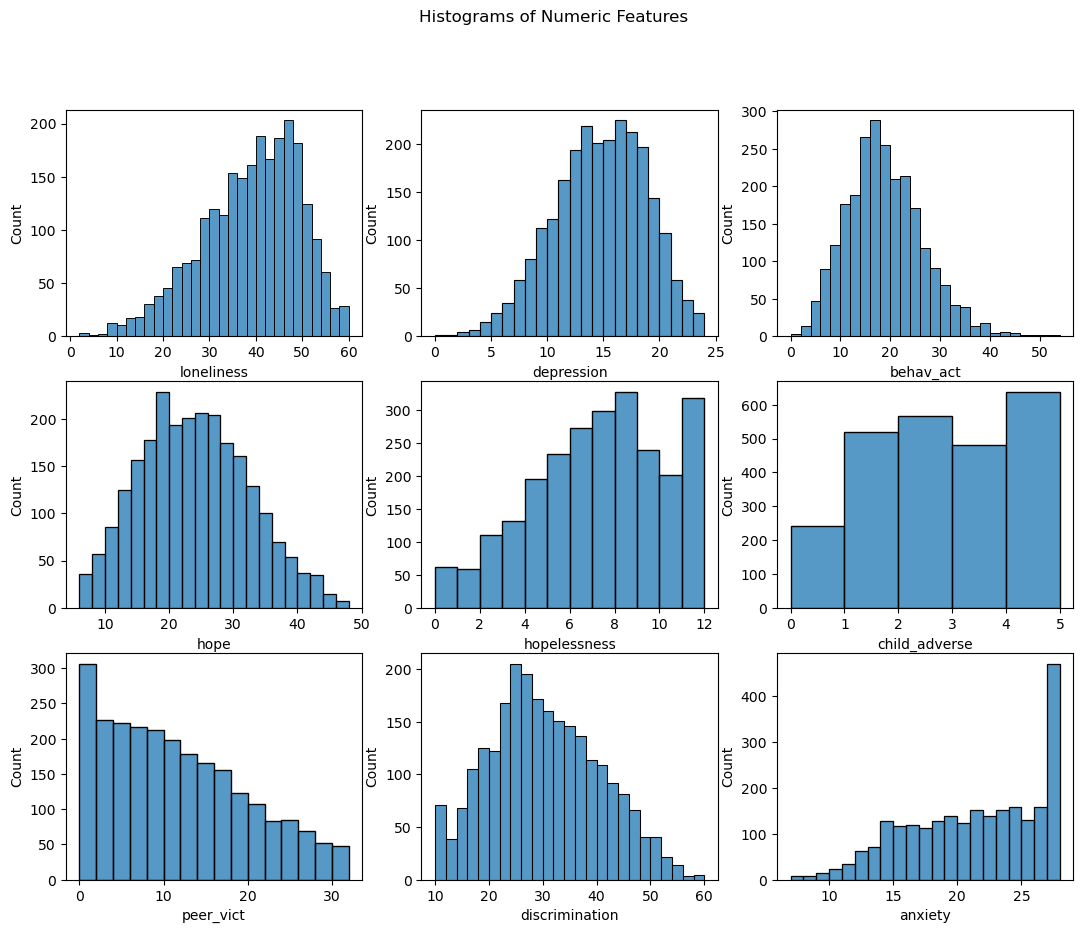

In [39]:
# histograms of numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Histograms of Numeric Features')

sns.histplot(ax=axes[0, 0], data=data['loneliness'], binwidth=2)
sns.histplot(ax=axes[0, 1], data=data['depression'], binwidth=1)
sns.histplot(ax=axes[0, 2], data=data['behav_act'], binwidth=2)
sns.histplot(ax=axes[1, 0], data=data['hope'], binwidth=2)
sns.histplot(ax=axes[1, 1], data=data['hopelessness'], binwidth=1)
sns.histplot(ax=axes[1, 2], data=data['child_adverse'], binwidth=1)
sns.histplot(ax=axes[2, 0], data=data['peer_vict'], binwidth=2)
sns.histplot(ax=axes[2, 1], data=data['discrimination'], binwidth=2)
sns.histplot(ax=axes[2, 2], data=data['anxiety'], binwidth=1)

# don't show unnecessary output about object
None

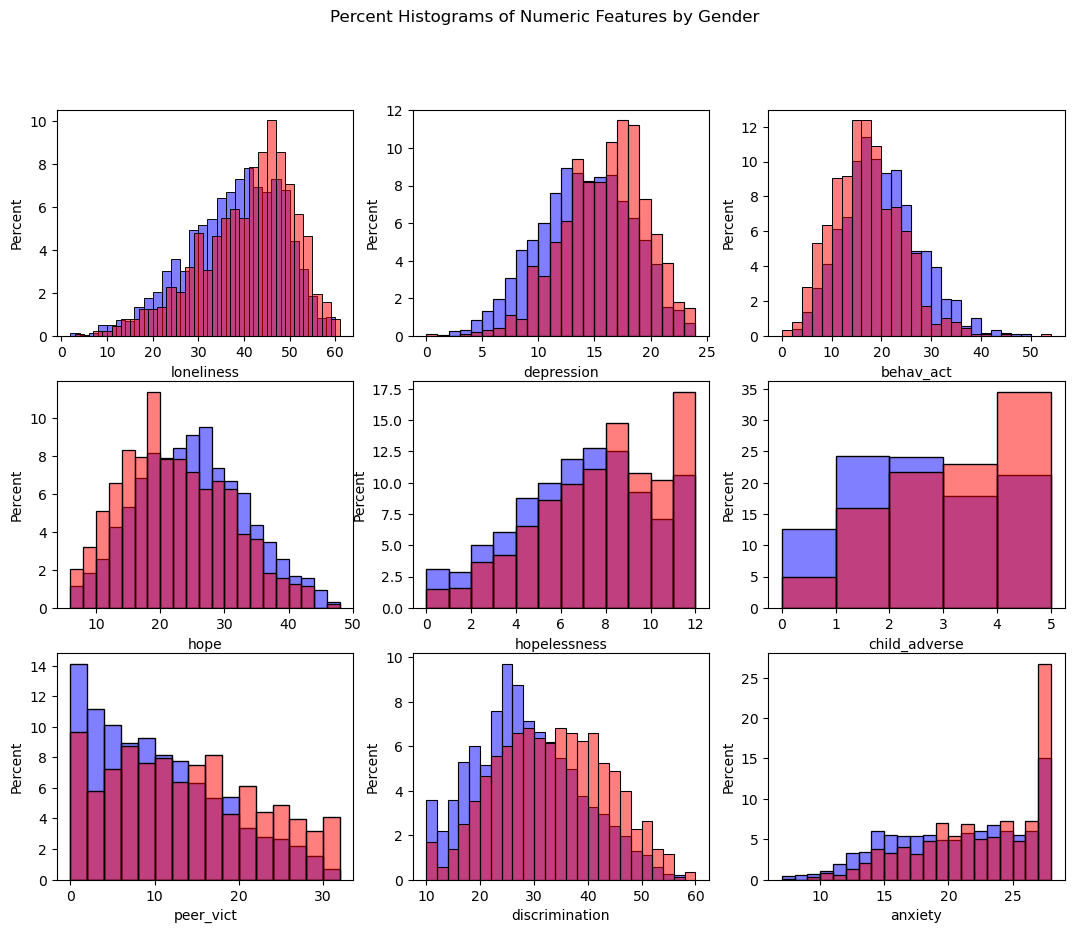

In [40]:
# histograms of numeric features by gender group

# create subsets of data for each gender group
data_cis = data[data['gender'] != 'gender_diverse'].copy()
data_minor = data[data['gender'] == 'gender_diverse'].copy()

fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Percent Histograms of Numeric Features by Gender')

sns.histplot(ax=axes[0, 0], data=data_cis['loneliness'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[0, 0], data=data_minor['loneliness'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[0, 1], data=data_cis['depression'], stat='percent', binwidth=1, color='blue', alpha=0.5)
sns.histplot(ax=axes[0, 1], data=data_minor['depression'], stat='percent', binwidth=1, color='red', alpha=0.5)
sns.histplot(ax=axes[0, 2], data=data_cis['behav_act'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[0, 2], data=data_minor['behav_act'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[1, 0], data=data_cis['hope'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[1, 0], data=data_minor['hope'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[1, 1], data=data_cis['hopelessness'], stat='percent', binwidth=1, color='blue', alpha=0.5)
sns.histplot(ax=axes[1, 1], data=data_minor['hopelessness'], stat='percent', binwidth=1, color='red', alpha=0.5)
sns.histplot(ax=axes[1, 2], data=data_cis['child_adverse'], stat='percent', binwidth=1, color='blue', alpha=0.5)
sns.histplot(ax=axes[1, 2], data=data_minor['child_adverse'], stat='percent', binwidth=1, color='red', alpha=0.5)
sns.histplot(ax=axes[2, 0], data=data_cis['peer_vict'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[2, 0], data=data_minor['peer_vict'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[2, 1], data=data_cis['discrimination'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[2, 1], data=data_minor['discrimination'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[2, 2], data=data_cis['anxiety'], stat='percent', binwidth=1, color='blue', alpha=0.5)
sns.histplot(ax=axes[2, 2], data=data_minor['anxiety'], stat='percent', binwidth=1, color='red', alpha=0.5)

# don't show unnecessary output about object
None

In the above plots, the lavender color corresponds to the cisgender group and the salmon color corresponds to the gender minority group.  
The deeper red color corresponds to areas of overlap.  
Because the groups differ in size, the vertical axis shows the percent of the distribution in each bin rather than the count.

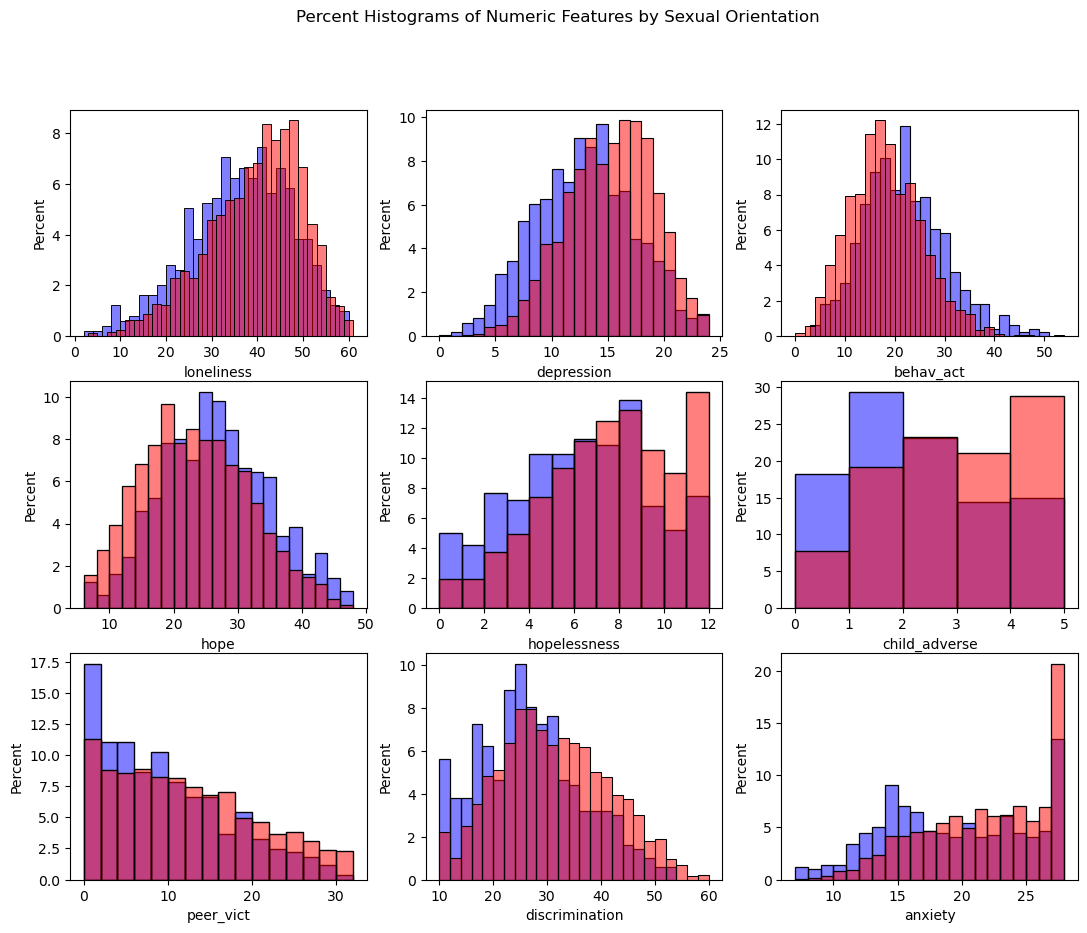

In [41]:
# histograms of numeric features by orientation group

# create subsets of data for each orientation group
data_hetero = data[data['orientation'] == 'Heterosexual/Straight'].copy()
data_minor = data[data['orientation'] != 'Heterosexual/Straight'].copy()

fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Percent Histograms of Numeric Features by Sexual Orientation')

sns.histplot(ax=axes[0, 0], data=data_hetero['loneliness'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[0, 0], data=data_minor['loneliness'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[0, 1], data=data_hetero['depression'], stat='percent', binwidth=1, color='blue', alpha=0.5)
sns.histplot(ax=axes[0, 1], data=data_minor['depression'], stat='percent', binwidth=1, color='red', alpha=0.5)
sns.histplot(ax=axes[0, 2], data=data_hetero['behav_act'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[0, 2], data=data_minor['behav_act'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[1, 0], data=data_hetero['hope'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[1, 0], data=data_minor['hope'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[1, 1], data=data_hetero['hopelessness'], stat='percent', binwidth=1, color='blue', alpha=0.5)
sns.histplot(ax=axes[1, 1], data=data_minor['hopelessness'], stat='percent', binwidth=1, color='red', alpha=0.5)
sns.histplot(ax=axes[1, 2], data=data_hetero['child_adverse'], stat='percent', binwidth=1, color='blue', alpha=0.5)
sns.histplot(ax=axes[1, 2], data=data_minor['child_adverse'], stat='percent', binwidth=1, color='red', alpha=0.5)
sns.histplot(ax=axes[2, 0], data=data_hetero['peer_vict'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[2, 0], data=data_minor['peer_vict'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[2, 1], data=data_hetero['discrimination'], stat='percent', binwidth=2, color='blue', alpha=0.5)
sns.histplot(ax=axes[2, 1], data=data_minor['discrimination'], stat='percent', binwidth=2, color='red', alpha=0.5)
sns.histplot(ax=axes[2, 2], data=data_hetero['anxiety'], stat='percent', binwidth=1, color='blue', alpha=0.5)
sns.histplot(ax=axes[2, 2], data=data_minor['anxiety'], stat='percent', binwidth=1, color='red', alpha=0.5)

# don't show unnecessary output about object
None

In the above plots, the lavender color corresponds to the heterosexual group and the salmon color corresponds to the sexual minority group.  
The deeper red color corresponds to areas of overlap.  
Because the groups differ in size, the vertical axis shows the percent of the distribution in each bin rather than the count.

In [42]:
# examine correlations between numeric features
numeric_features = ['loneliness', 'depression', 'behav_act', 'hope', 'hopelessness', 
                    'child_adverse', 'peer_vict', 'discrimination', 'anxiety']
data[numeric_features].corr()

,loneliness,depression,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety
loneliness,1.000000,0.550011,-0.478647,-0.423158,0.508124,0.225473,0.272284,0.347911,0.380203
depression,0.550011,1.000000,-0.643446,-0.563095,0.634688,0.302187,0.322832,0.433894,0.564212
behav_act,-0.478647,-0.643446,1.000000,0.580059,-0.531347,-0.283846,-0.244080,-0.334728,-0.440418
hope,-0.423158,-0.563095,0.580059,1.000000,-0.594862,-0.189588,-0.175221,-0.238655,-0.274598
hopelessness,0.508124,0.634688,-0.531347,-0.594862,1.000000,0.172272,0.268169,0.340686,0.415289
child_adverse,0.225473,0.302187,-0.283846,-0.189588,0.172272,1.000000,0.263421,0.341760,0.268789
peer_vict,0.272284,0.322832,-0.244080,-0.175221,0.268169,0.263421,1.000000,0.625618,0.342707
discrimination,0.347911,0.433894,-0.334728,-0.238655,0.340686,0.341760,0.625618,1.000000,0.421275
anxiety,0.380203,0.564212,-0.440418,-0.274598,0.415289,0.268789,0.342707,0.421275,1.000000


<Axes: >

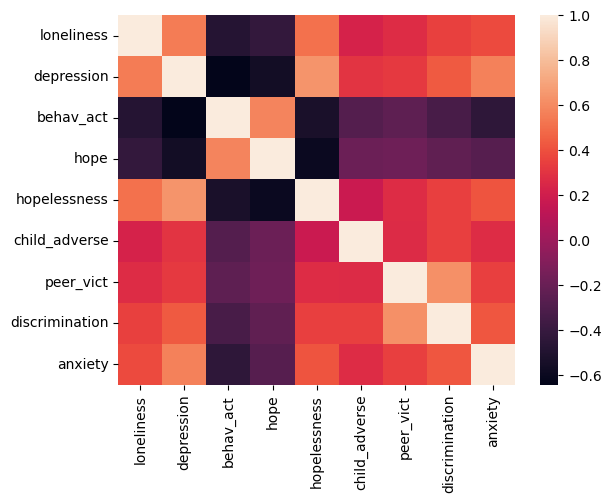

In [43]:
# visualize correlations
sns.heatmap(data[numeric_features].corr())

We can see some expected relationships.   
Strong correlations between loneliness, hopelessness, depression, and anxiety  
These tend to be inversely related to behavioral activation and hope.  
Also strong correlation between discrimination and peer victimization  
In general, a lot of correlation among predictors

### Features: categorical

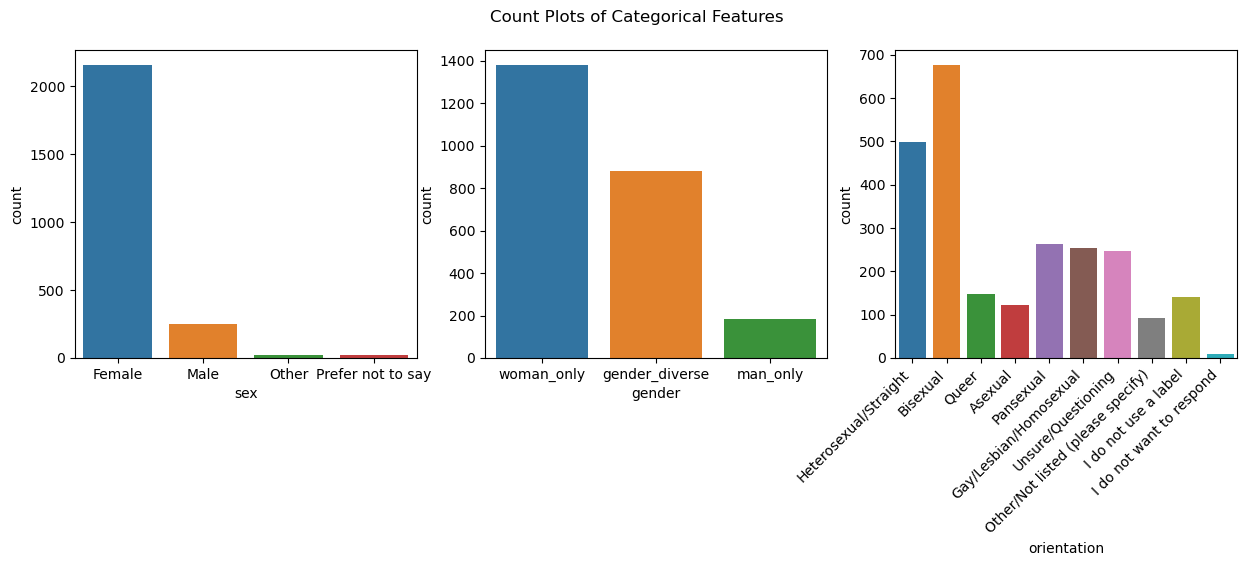

In [44]:
# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Features')

sns.countplot(ax=axes[0], x=data['sex'])

sns.countplot(ax=axes[1], x=data['gender'])

sns.countplot(ax=axes[2], x=data['orientation'])

plt.xticks(rotation=45, horizontalalignment='right')
None

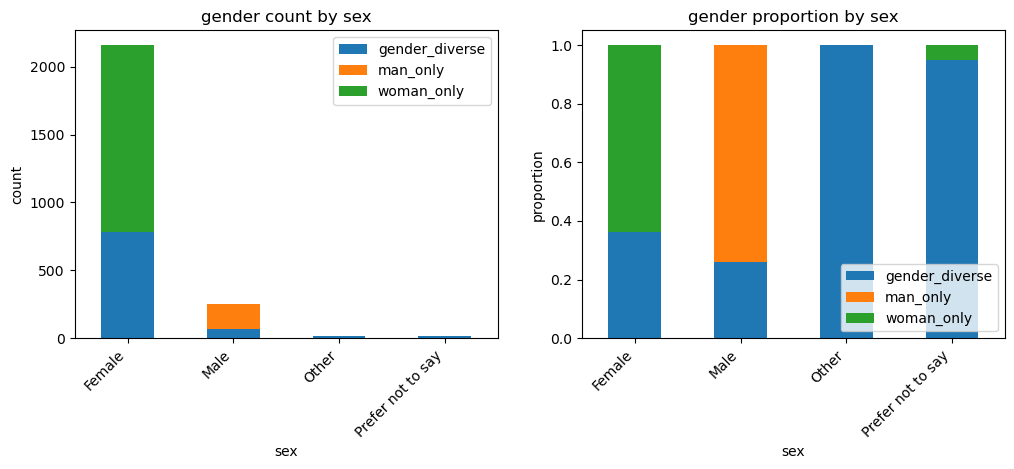

In [45]:
# examining distribution of gender by sex
cross_tab_sex_gender = pd.crosstab(index=data['sex'], columns=data['gender'])
cross_tab_sex_gender_norm = pd.crosstab(index=data['sex'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_sex_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("sex")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by sex")

cross_tab_sex_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("sex")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by sex")

None

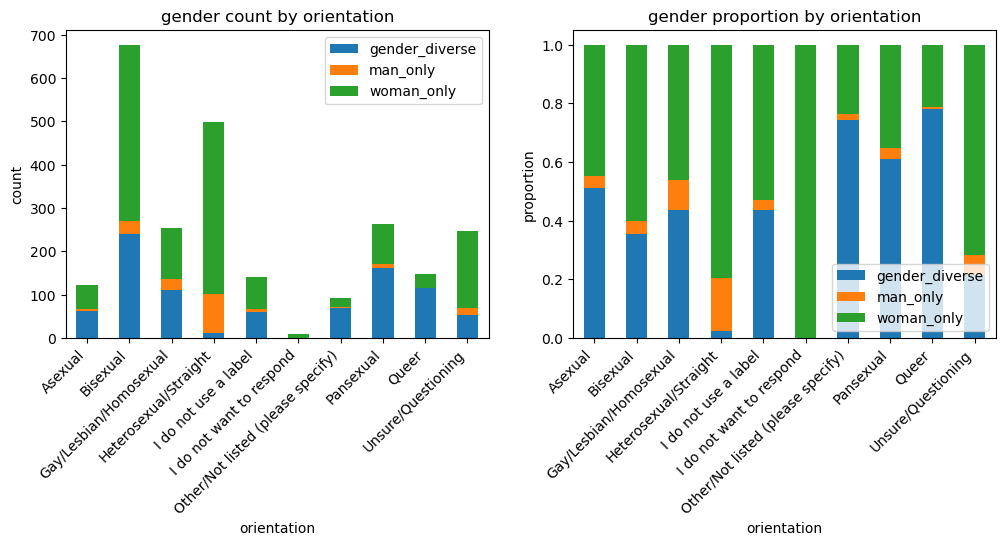

In [46]:
# examining distribution of gender by orientation
cross_tab_orient_gender = pd.crosstab(index=data['orientation'], columns=data['gender'])
cross_tab_orient_gender_norm = pd.crosstab(index=data['orientation'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_orient_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("orientation")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by orientation")

cross_tab_orient_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("orientation")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by orientation")

None

### Targets: numeric

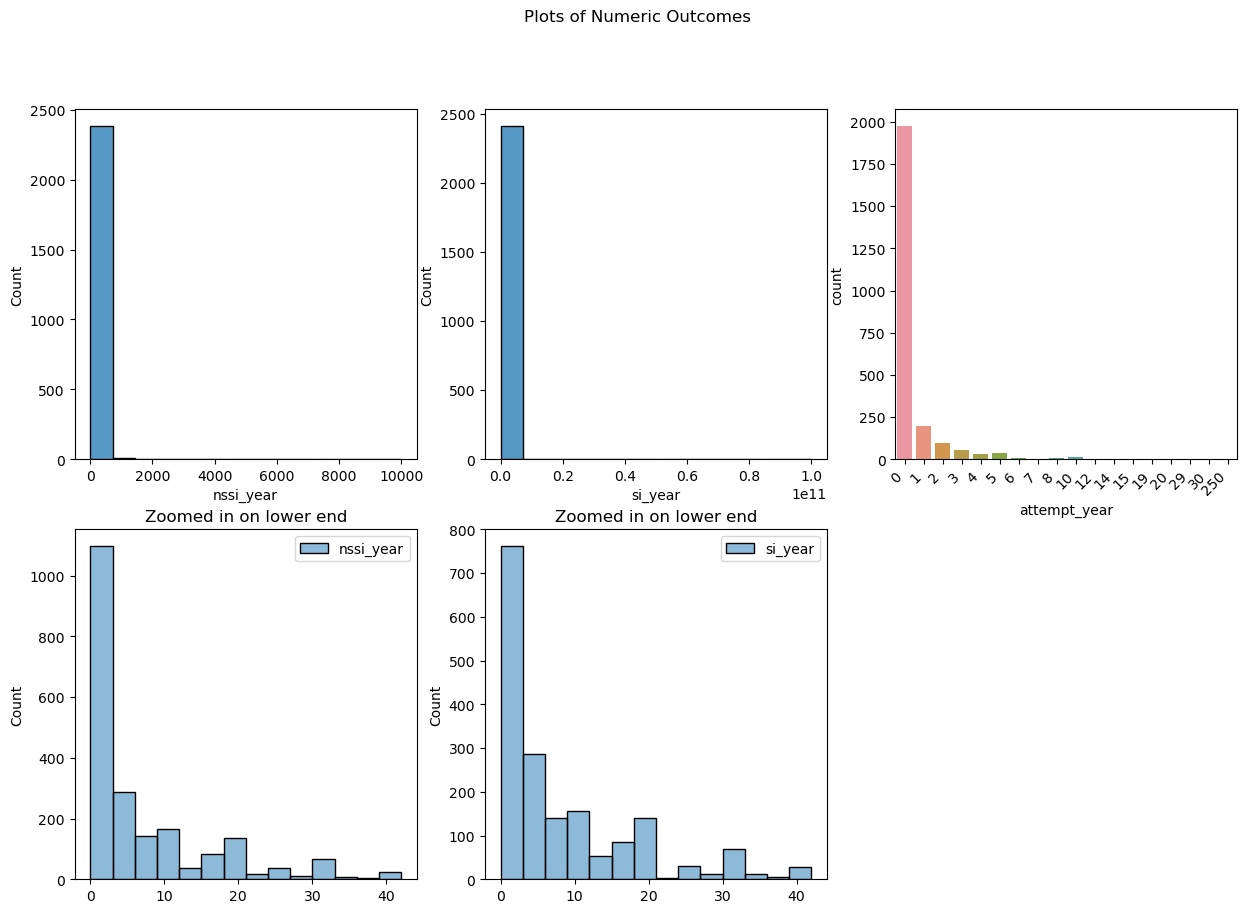

In [47]:
# plots of numeric targets
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Plots of Numeric Outcomes')

sns.histplot(ax=axes[0, 0], data=data['nssi_year'], bins=14)

sns.histplot(ax=axes[0, 1], data=data['si_year'], bins=14)

sns.countplot(ax=axes[0, 2], x=data.loc[data['attempt_year'].notna(), 'attempt_year'].astype('int'))
plt.sca(axes[0, 2])
plt.xticks(rotation=45, horizontalalignment='right')

sns.histplot(ax=axes[1, 0], data=data.loc[data['nssi_year'] < 43, ['nssi_year']], bins=14)
axes[1, 0].set_title("Zoomed in on lower end")

sns.histplot(ax=axes[1, 1], data=data.loc[data['si_year'] < 43, ['si_year']], bins=14)
axes[1, 1].set_title("Zoomed in on lower end")

fig.delaxes(axes[1, 2])

None

In [48]:
# examine correlations between outcome variables
data[['nssi_year', 'si_year', 'attempt_year']].corr()

,nssi_year,si_year,attempt_year
nssi_year,1.000000,0.049948,0.068214
si_year,0.049948,1.000000,0.012383
attempt_year,0.068214,0.012383,1.000000


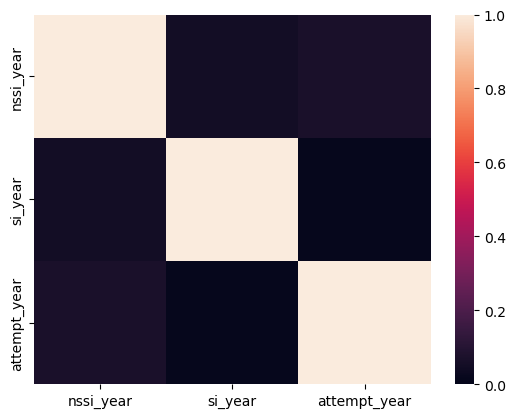

In [49]:
# visualize correlations
sns.heatmap(data[['nssi_year', 'si_year', 'attempt_year']].corr(), vmin=0, vmax=1)
None

Suprisingly little correlation between numeric outcome variables?

In [50]:
# limit some extremely large response values for outcome year variables
# to avoid issues related to extreme outliers and/or unrealistic values

# for nssi, 1000 would correspond roughly to average of 3 per day
data.loc[data['nssi_year'] > 1000, 'nssi_year'] = 1000

# same for si
data.loc[data['si_year'] > 1000, 'si_year'] = 1000

# for attempt, only one value greater than 30, will cap at 50
data.loc[data['attempt_year'] > 30, 'attempt_year'] = 50

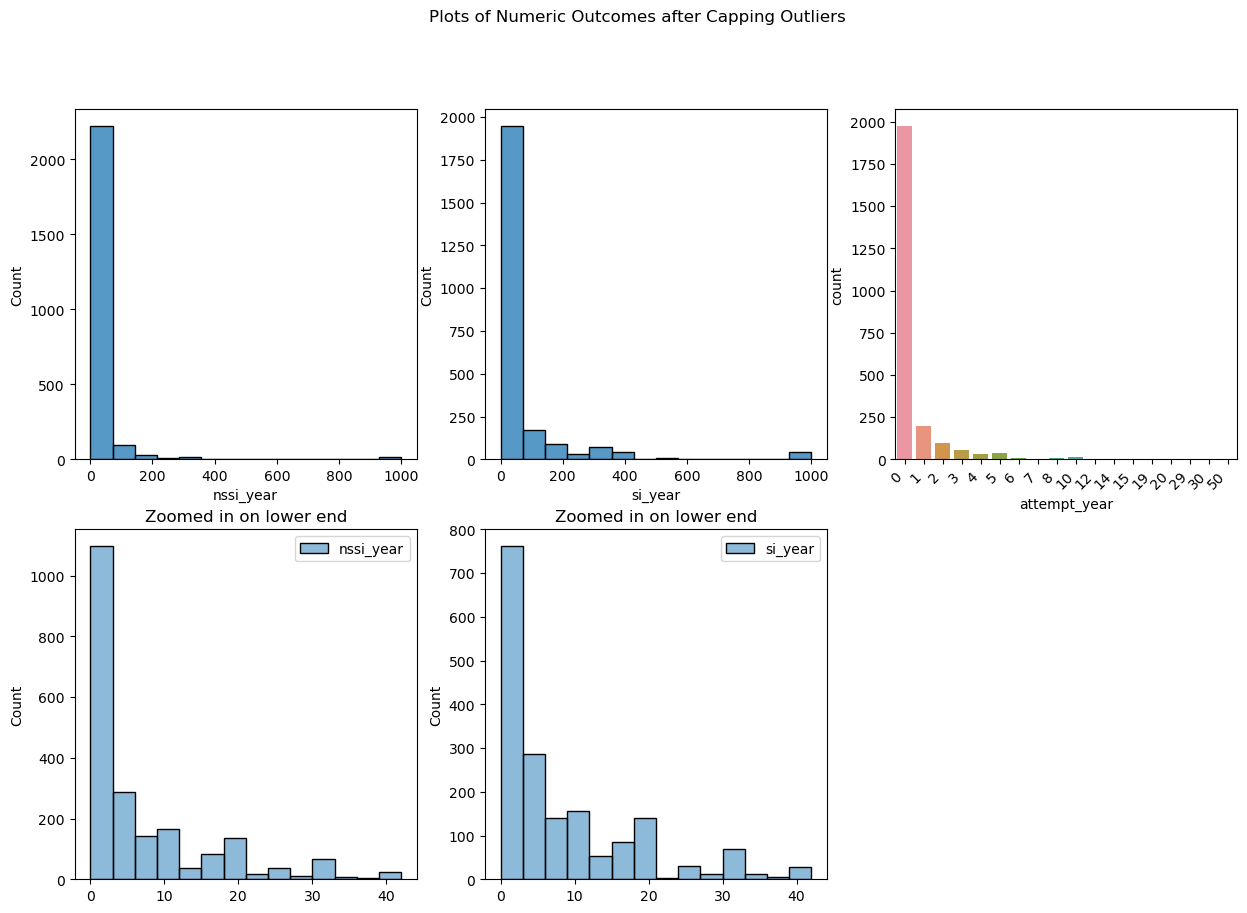

In [51]:
# redo plots and correlations of outcomes after constraining outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Plots of Numeric Outcomes after Capping Outliers')

sns.histplot(ax=axes[0, 0], data=data['nssi_year'], bins=14)

sns.histplot(ax=axes[0, 1], data=data['si_year'], bins=14)

sns.countplot(ax=axes[0, 2], x=data.loc[data['attempt_year'].notna(), 'attempt_year'].astype('int'))
plt.sca(axes[0, 2])
plt.xticks(rotation=45, horizontalalignment='right')

sns.histplot(ax=axes[1, 0], data=data.loc[data['nssi_year'] < 43, ['nssi_year']], bins=14)
axes[1, 0].set_title("Zoomed in on lower end")

sns.histplot(ax=axes[1, 1], data=data.loc[data['si_year'] < 43, ['si_year']], bins=14)
axes[1, 1].set_title("Zoomed in on lower end")

fig.delaxes(axes[1, 2])

None

In [52]:
data[['nssi_year', 'si_year', 'attempt_year']].corr()

,nssi_year,si_year,attempt_year
nssi_year,1.000000,0.313511,0.165091
si_year,0.313511,1.000000,0.229054
attempt_year,0.165091,0.229054,1.000000


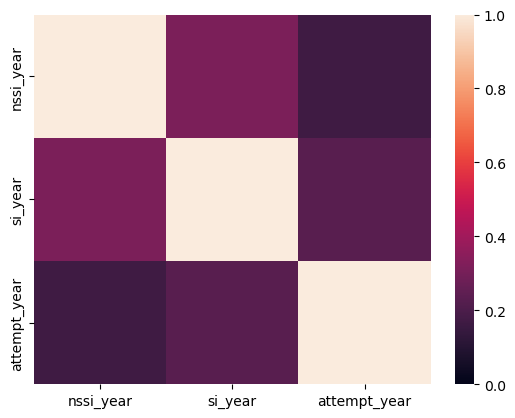

In [53]:
sns.heatmap(data[['nssi_year', 'si_year', 'attempt_year']].corr(), vmin=0, vmax=1)
None

Constraining outliers did increase correlations, but they are still small-to-moderate.

### Targets: categorical

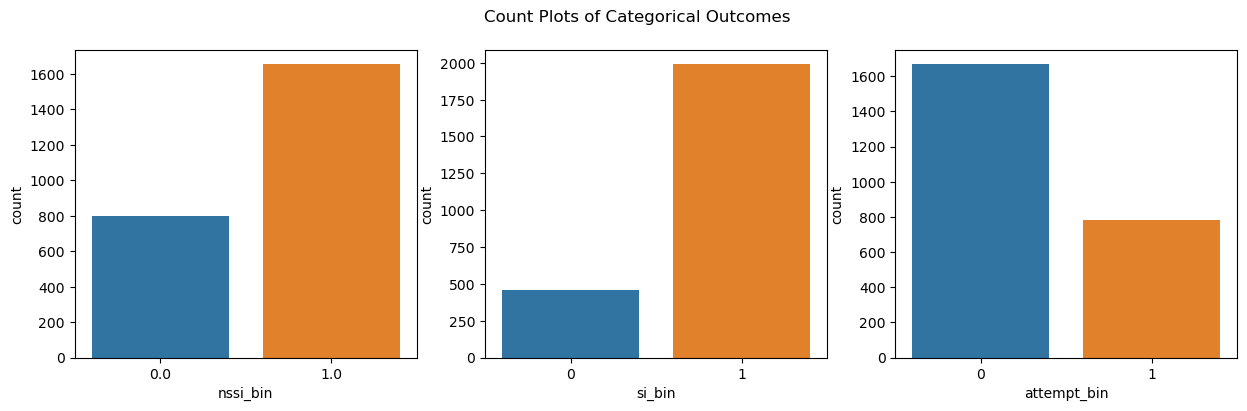

In [54]:
# count plots of categorical target variables

# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Outcomes')

sns.countplot(ax=axes[0], x=data['nssi_bin'])

sns.countplot(ax=axes[1], x=data['si_bin'])

sns.countplot(ax=axes[2], x=data['attempt_bin'])

None

0 = have never engaged in thought/behavior, 1 = have engaged in thought/behavior

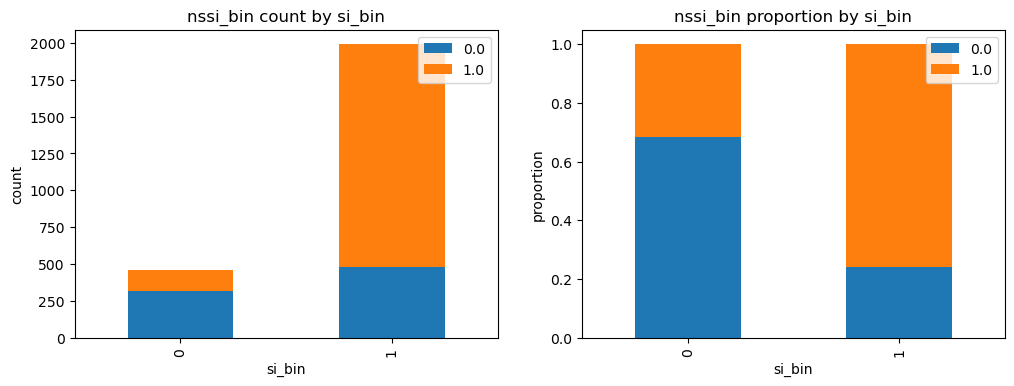

In [55]:
# examining distribution of si_bin by nssi_bin
cross_tab_si_nssi = pd.crosstab(index=data['si_bin'], columns=data['nssi_bin'])
cross_tab_si_nssi_norm = pd.crosstab(index=data['si_bin'], columns=data['nssi_bin'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_si_nssi.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("si_bin")
axes[0].set_ylabel("count")
axes[0].set_title("nssi_bin count by si_bin")

cross_tab_si_nssi_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="upper right", ncol=1)
axes[1].set_xlabel("si_bin")
axes[1].set_ylabel("proportion")
axes[1].set_title("nssi_bin proportion by si_bin")

None

0 = have never engaged in thought/behavior, 1 = have engaged in thought/behavior

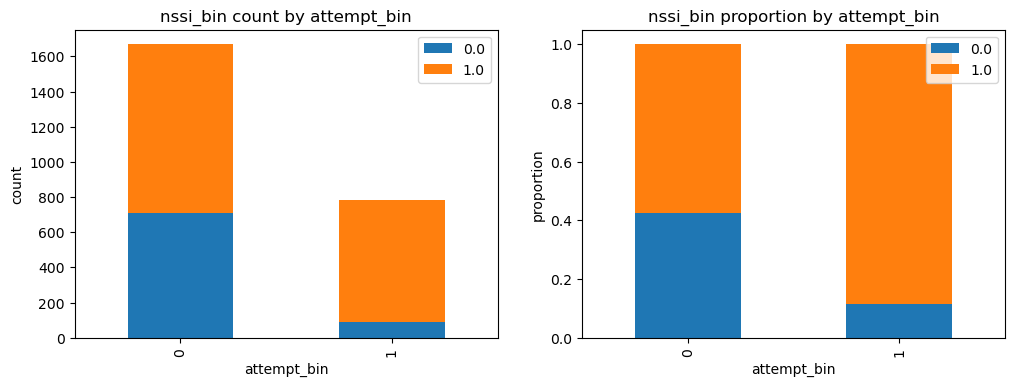

In [56]:
# examining distribution of attempt_bin by nssi_bin
cross_tab_attempt_nssi = pd.crosstab(index=data['attempt_bin'], columns=data['nssi_bin'])
cross_tab_attempt_nssi_norm = pd.crosstab(index=data['attempt_bin'], columns=data['nssi_bin'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_attempt_nssi.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("attempt_bin")
axes[0].set_ylabel("count")
axes[0].set_title("nssi_bin count by attempt_bin")

cross_tab_attempt_nssi_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="upper right", ncol=1)
axes[1].set_xlabel("attempt_bin")
axes[1].set_ylabel("proportion")
axes[1].set_title("nssi_bin proportion by attempt_bin")

None

0 = have never engaged in thought/behavior, 1 = have engaged in thought/behavior

### Target-feature relationships

In [57]:
# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns)],
    remainder='passthrough')

# preprocess features
features_full = preprocessor.fit_transform(features)
features_full = KNNImputer(n_neighbors=5).fit_transform(features_full)
feature_names = list(preprocessor.named_transformers_['categorical'].get_feature_names_out()) + list(numeric_columns)
features_full = pd.DataFrame(features_full, columns=feature_names)

# define function to compute mutual information scores
def make_mi_scores(X, y, classify=1):
    if classify == 1:
        mi_scores = mutual_info_classif(X, y, discrete_features=True)
    else:
        mi_scores = mutual_info_regression(X, y, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [58]:
mi_nssi_bin = make_mi_scores(features_full, data['nssi_bin'])
print(mi_nssi_bin)

depression                                       0.058059
discrimination                                   0.047545
behav_act                                        0.040059
anxiety                                          0.038831
child_adverse                                    0.035500
loneliness                                       0.034072
peer_vict                                        0.029190
hopelessness                                     0.024562
orientation_Heterosexual/Straight                0.024001
gender_gender_diverse                            0.023010
hope                                             0.021065
sex_Male                                         0.008679
gender_man_only                                  0.008665
gender_woman_only                                0.008563
sex_Female                                       0.006742
orientation_Bisexual                             0.005374
orientation_Pansexual                            0.004053
orientation_Qu

C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

In [59]:
mi_si_bin = make_mi_scores(features_full, data['si_bin'])
print(mi_si_bin)

depression                                       0.057696
behav_act                                        0.042808
child_adverse                                    0.038627
loneliness                                       0.037754
anxiety                                          0.034068
discrimination                                   0.033243
hope                                             0.027037
hopelessness                                     0.026513
orientation_Heterosexual/Straight                0.020319
peer_vict                                        0.017563
gender_gender_diverse                            0.011705
orientation_Bisexual                             0.005213
gender_man_only                                  0.004941
sex_Male                                         0.004114
gender_woman_only                                0.003800
sex_Female                                       0.002604
orientation_Pansexual                            0.002442
orientation_Qu

C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

In [60]:
mi_attempt_bin = make_mi_scores(features_full, data['attempt_bin'])
print(mi_attempt_bin)

discrimination                                   0.070808
depression                                       0.065083
peer_vict                                        0.045422
child_adverse                                    0.045169
behav_act                                        0.041544
anxiety                                          0.038679
loneliness                                       0.035958
hopelessness                                     0.030539
hope                                             0.027976
gender_gender_diverse                            0.014108
orientation_Heterosexual/Straight                0.011849
gender_woman_only                                0.008375
orientation_Pansexual                            0.005362
gender_man_only                                  0.002199
sex_Male                                         0.001964
orientation_I do not want to respond             0.001574
orientation_Bisexual                             0.001252
orientation_Qu

C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\u364149\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

In [61]:
nulls = data['nssi_year'].isna()
mi_nssi_year = make_mi_scores(features_full[nulls == 0], data['nssi_year'][nulls == 0], 0)
print(mi_nssi_year)

depression                                       0.078045
peer_vict                                        0.065944
discrimination                                   0.058121
anxiety                                          0.056388
gender_gender_diverse                            0.040340
loneliness                                       0.031661
behav_act                                        0.031217
child_adverse                                    0.029631
hopelessness                                     0.028838
gender_woman_only                                0.021354
orientation_Heterosexual/Straight                0.020651
hope                                             0.019982
gender_man_only                                  0.017423
sex_Male                                         0.009669
sex_Female                                       0.008068
orientation_Queer                                0.007013
orientation_Pansexual                            0.006749
orientation_Un

In [62]:
nulls = data['si_year'].isna()
mi_si_year = make_mi_scores(features_full[nulls == 0], data['si_year'][nulls == 0], 0)
print(mi_si_year)

depression                                       0.148878
anxiety                                          0.105173
hopelessness                                     0.082700
behav_act                                        0.078242
loneliness                                       0.068602
hope                                             0.061586
child_adverse                                    0.047857
discrimination                                   0.042086
peer_vict                                        0.030353
orientation_Heterosexual/Straight                0.025858
orientation_Bisexual                             0.023713
gender_gender_diverse                            0.021608
sex_Female                                       0.017932
sex_Male                                         0.014741
gender_woman_only                                0.014105
gender_man_only                                  0.008793
orientation_Unsure/Questioning                   0.005083
sex_Prefer not

In [63]:
nulls = data['attempt_year'].isna()
mi_attempt_year = make_mi_scores(features_full[nulls == 0], data['attempt_year'][nulls == 0], 0)
print(mi_attempt_year)

anxiety                                          0.058305
discrimination                                   0.052823
hopelessness                                     0.040314
loneliness                                       0.038699
hope                                             0.030268
depression                                       0.027859
peer_vict                                        0.026414
behav_act                                        0.024314
child_adverse                                    0.013626
gender_woman_only                                0.013154
gender_gender_diverse                            0.011950
orientation_Asexual                              0.009893
orientation_Heterosexual/Straight                0.009026
orientation_Pansexual                            0.007240
sex_Female                                       0.004272
orientation_I do not use a label                 0.003479
gender_man_only                                  0.003302
sex_Male      

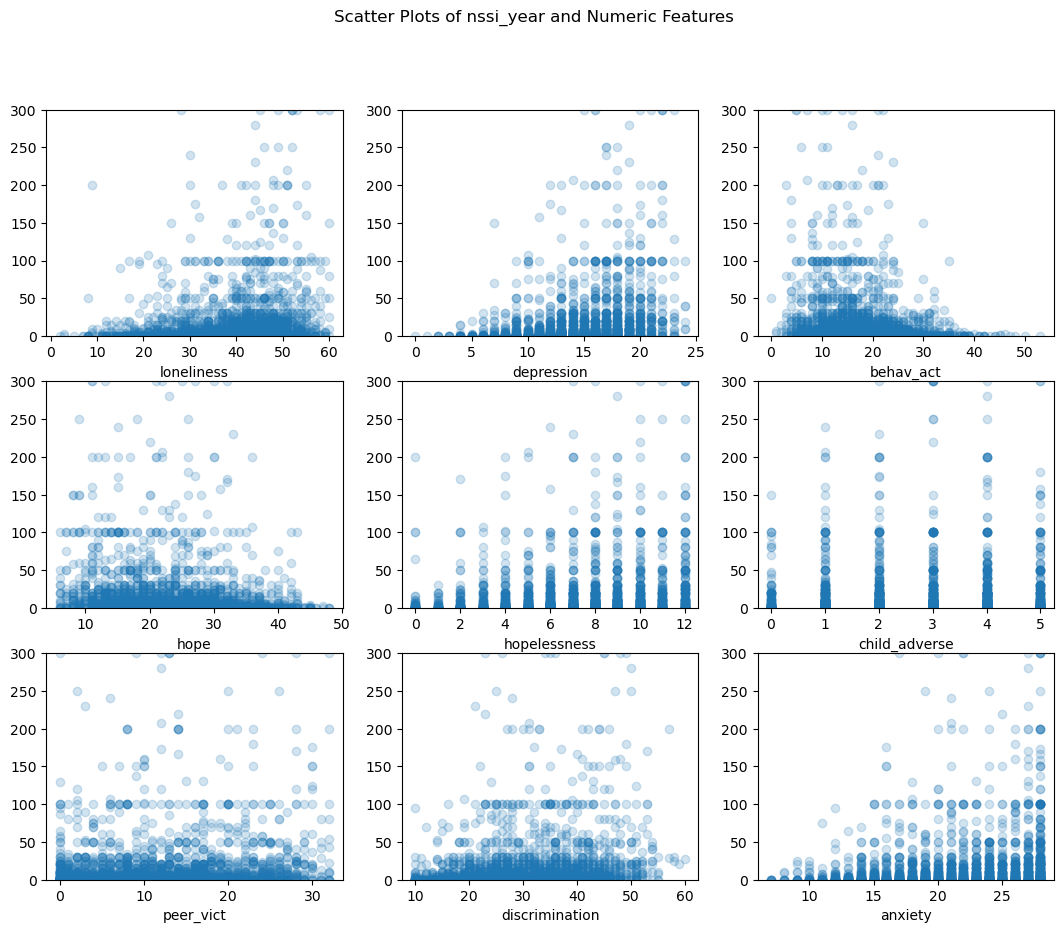

In [64]:
## visually examine numeric features for polynomial relationships
# nssi_year vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of nssi_year and Numeric Features')

axes[0,0].scatter(data['loneliness'], data['nssi_year'], alpha=0.2)
axes[0,0].set_xlabel('loneliness')
axes[0,0].set_ylim(0, 300)
axes[0,1].scatter(data['depression'], data['nssi_year'], alpha=0.2)
axes[0,1].set_xlabel('depression')
axes[0,1].set_ylim(0, 300)
axes[0,2].scatter(data['behav_act'], data['nssi_year'], alpha=0.2)
axes[0,2].set_xlabel('behav_act')
axes[0,2].set_ylim(0, 300)
axes[1,0].scatter(data['hope'], data['nssi_year'], alpha=0.2)
axes[1,0].set_xlabel('hope')
axes[1,0].set_ylim(0, 300)
axes[1,1].scatter(data['hopelessness'], data['nssi_year'], alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
axes[1,1].set_ylim(0, 300)
axes[1,2].scatter(data['child_adverse'], data['nssi_year'], alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
axes[1,2].set_ylim(0, 300)
axes[2,0].scatter(data['peer_vict'], data['nssi_year'], alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
axes[2,0].set_ylim(0, 300)
axes[2,1].scatter(data['discrimination'], data['nssi_year'], alpha=0.2)
axes[2,1].set_xlabel('discrimination')
axes[2,1].set_ylim(0, 300)
axes[2,2].scatter(data['anxiety'], data['nssi_year'], alpha=0.2)
axes[2,2].set_xlabel('anxiety')
axes[2,2].set_ylim(0, 300)

None

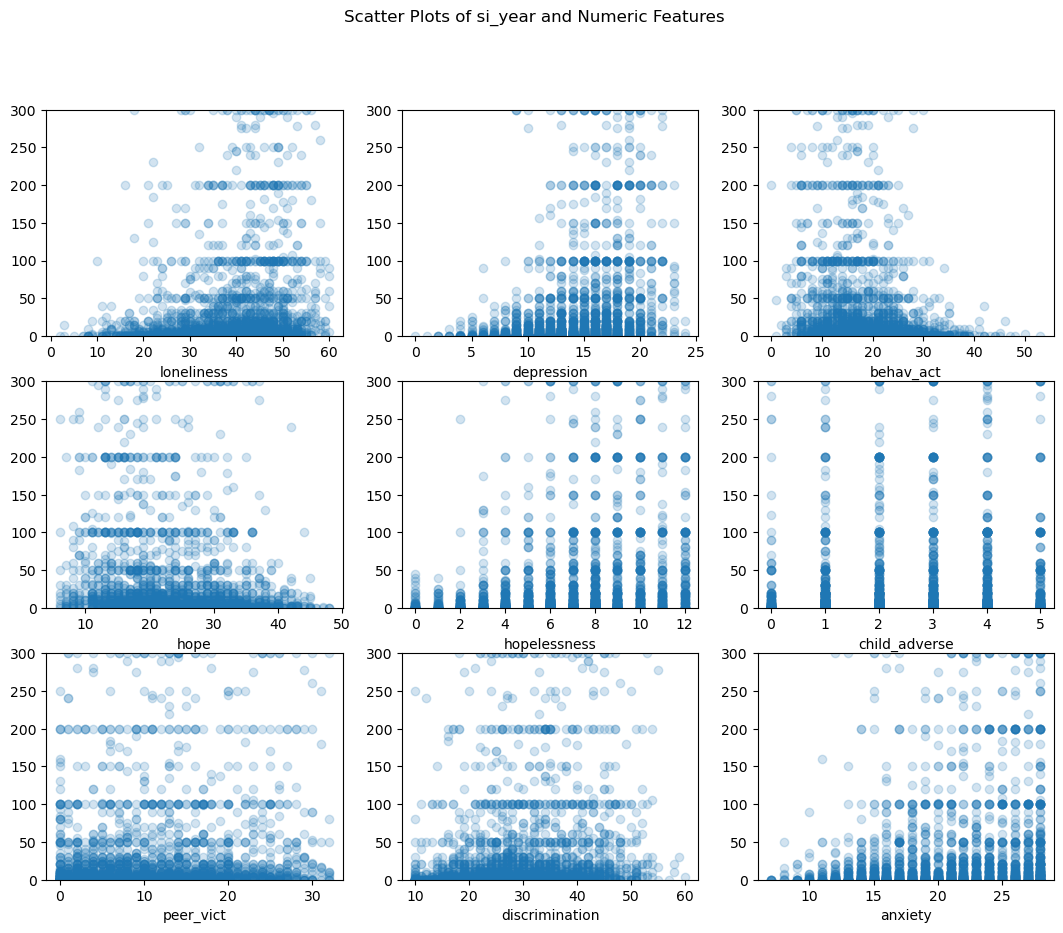

In [65]:
# si_year vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of si_year and Numeric Features')

axes[0,0].scatter(data['loneliness'], data['si_year'], alpha=0.2)
axes[0,0].set_xlabel('loneliness')
axes[0,0].set_ylim(0, 300)
axes[0,1].scatter(data['depression'], data['si_year'], alpha=0.2)
axes[0,1].set_xlabel('depression')
axes[0,1].set_ylim(0, 300)
axes[0,2].scatter(data['behav_act'], data['si_year'], alpha=0.2)
axes[0,2].set_xlabel('behav_act')
axes[0,2].set_ylim(0, 300)
axes[1,0].scatter(data['hope'], data['si_year'], alpha=0.2)
axes[1,0].set_xlabel('hope')
axes[1,0].set_ylim(0, 300)
axes[1,1].scatter(data['hopelessness'], data['si_year'], alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
axes[1,1].set_ylim(0, 300)
axes[1,2].scatter(data['child_adverse'], data['si_year'], alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
axes[1,2].set_ylim(0, 300)
axes[2,0].scatter(data['peer_vict'], data['si_year'], alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
axes[2,0].set_ylim(0, 300)
axes[2,1].scatter(data['discrimination'], data['si_year'], alpha=0.2)
axes[2,1].set_xlabel('discrimination')
axes[2,1].set_ylim(0, 300)
axes[2,2].scatter(data['anxiety'], data['si_year'], alpha=0.2)
axes[2,2].set_xlabel('anxiety')
axes[2,2].set_ylim(0, 300)

None

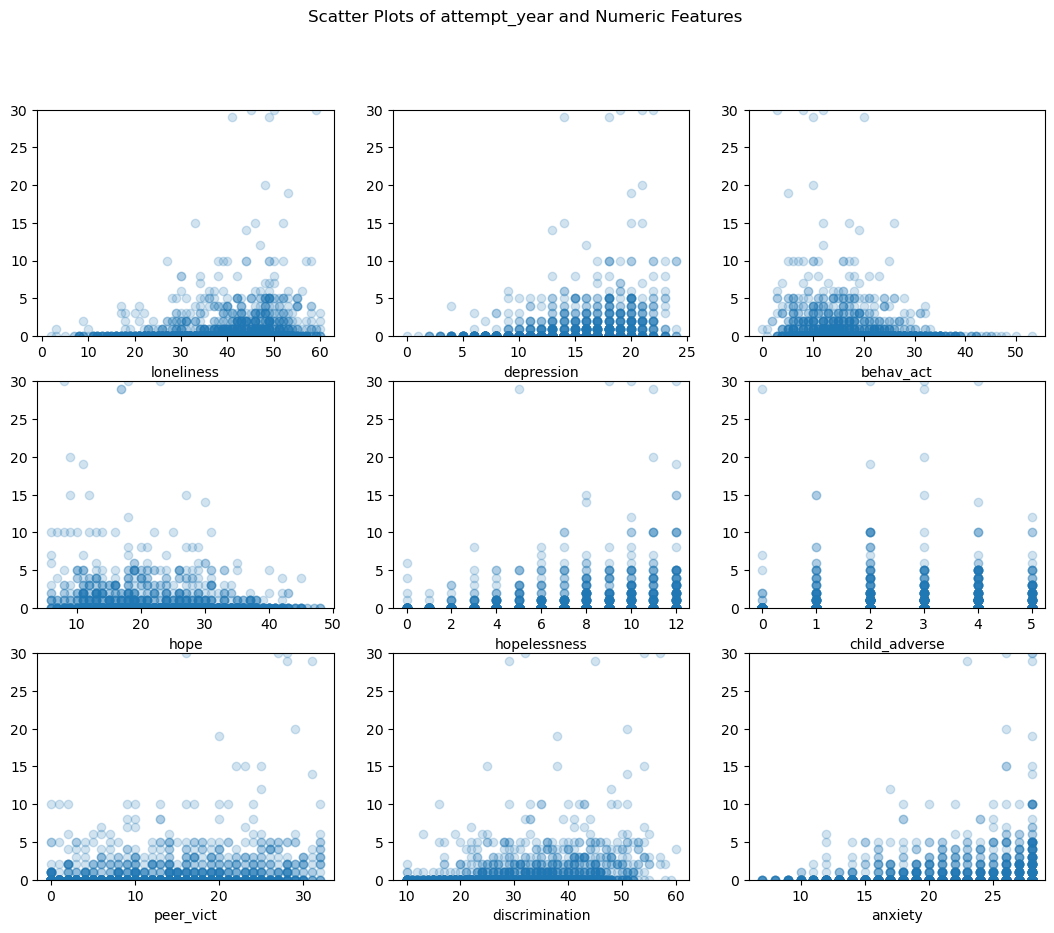

In [66]:
# attempt_year vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of attempt_year and Numeric Features')

axes[0,0].scatter(data['loneliness'], data['attempt_year'], alpha=0.2)
axes[0,0].set_xlabel('loneliness')
axes[0,0].set_ylim(0, 30)
axes[0,1].scatter(data['depression'], data['attempt_year'], alpha=0.2)
axes[0,1].set_xlabel('depression')
axes[0,1].set_ylim(0, 30)
axes[0,2].scatter(data['behav_act'], data['attempt_year'], alpha=0.2)
axes[0,2].set_xlabel('behav_act')
axes[0,2].set_ylim(0, 30)
axes[1,0].scatter(data['hope'], data['attempt_year'], alpha=0.2)
axes[1,0].set_xlabel('hope')
axes[1,0].set_ylim(0, 30)
axes[1,1].scatter(data['hopelessness'], data['attempt_year'], alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
axes[1,1].set_ylim(0, 30)
axes[1,2].scatter(data['child_adverse'], data['attempt_year'], alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
axes[1,2].set_ylim(0, 30)
axes[2,0].scatter(data['peer_vict'], data['attempt_year'], alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
axes[2,0].set_ylim(0, 30)
axes[2,1].scatter(data['discrimination'], data['attempt_year'], alpha=0.2)
axes[2,1].set_xlabel('discrimination')
axes[2,1].set_ylim(0, 30)
axes[2,2].scatter(data['anxiety'], data['attempt_year'], alpha=0.2)
axes[2,2].set_xlabel('anxiety')
axes[2,2].set_ylim(0, 30)

None

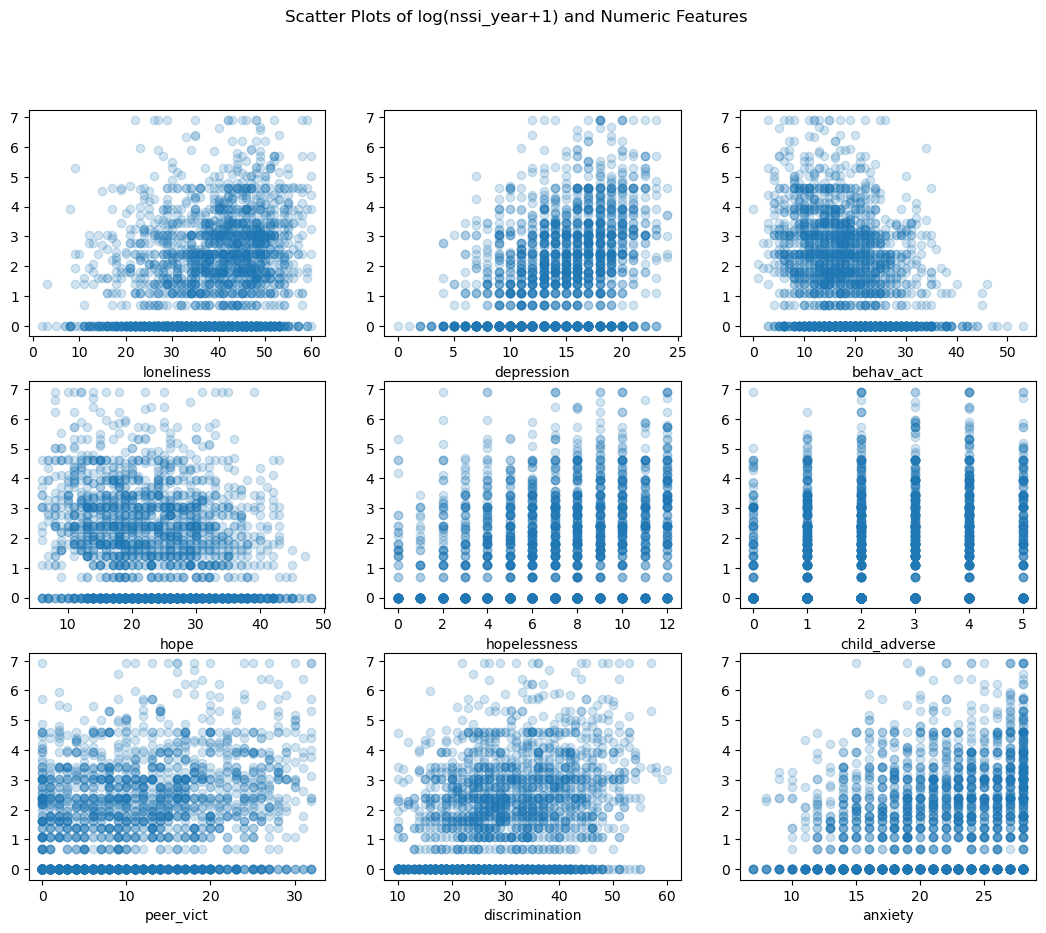

In [67]:
# log(nssi_year+1) vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of log(nssi_year+1) and Numeric Features')

axes[0,0].scatter(data['loneliness'], np.log(1+data['nssi_year']), alpha=0.2)
axes[0,0].set_xlabel('loneliness')
#axes[0,0].set_ylim(0, 300)
axes[0,1].scatter(data['depression'], np.log(1+data['nssi_year']), alpha=0.2)
axes[0,1].set_xlabel('depression')
#axes[0,1].set_ylim(0, 300)
axes[0,2].scatter(data['behav_act'], np.log(1+data['nssi_year']), alpha=0.2)
axes[0,2].set_xlabel('behav_act')
#axes[0,2].set_ylim(0, 300)
axes[1,0].scatter(data['hope'], np.log(1+data['nssi_year']), alpha=0.2)
axes[1,0].set_xlabel('hope')
#axes[1,0].set_ylim(0, 300)
axes[1,1].scatter(data['hopelessness'], np.log(1+data['nssi_year']), alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
#axes[1,1].set_ylim(0, 300)
axes[1,2].scatter(data['child_adverse'], np.log(1+data['nssi_year']), alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
#axes[1,2].set_ylim(0, 300)
axes[2,0].scatter(data['peer_vict'], np.log(1+data['nssi_year']), alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
#axes[2,0].set_ylim(0, 300)
axes[2,1].scatter(data['discrimination'], np.log(1+data['nssi_year']), alpha=0.2)
axes[2,1].set_xlabel('discrimination')
#axes[2,1].set_ylim(0, 300)
axes[2,2].scatter(data['anxiety'], np.log(1+data['nssi_year']), alpha=0.2)
axes[2,2].set_xlabel('anxiety')
#axes[2,2].set_ylim(0, 300)

None

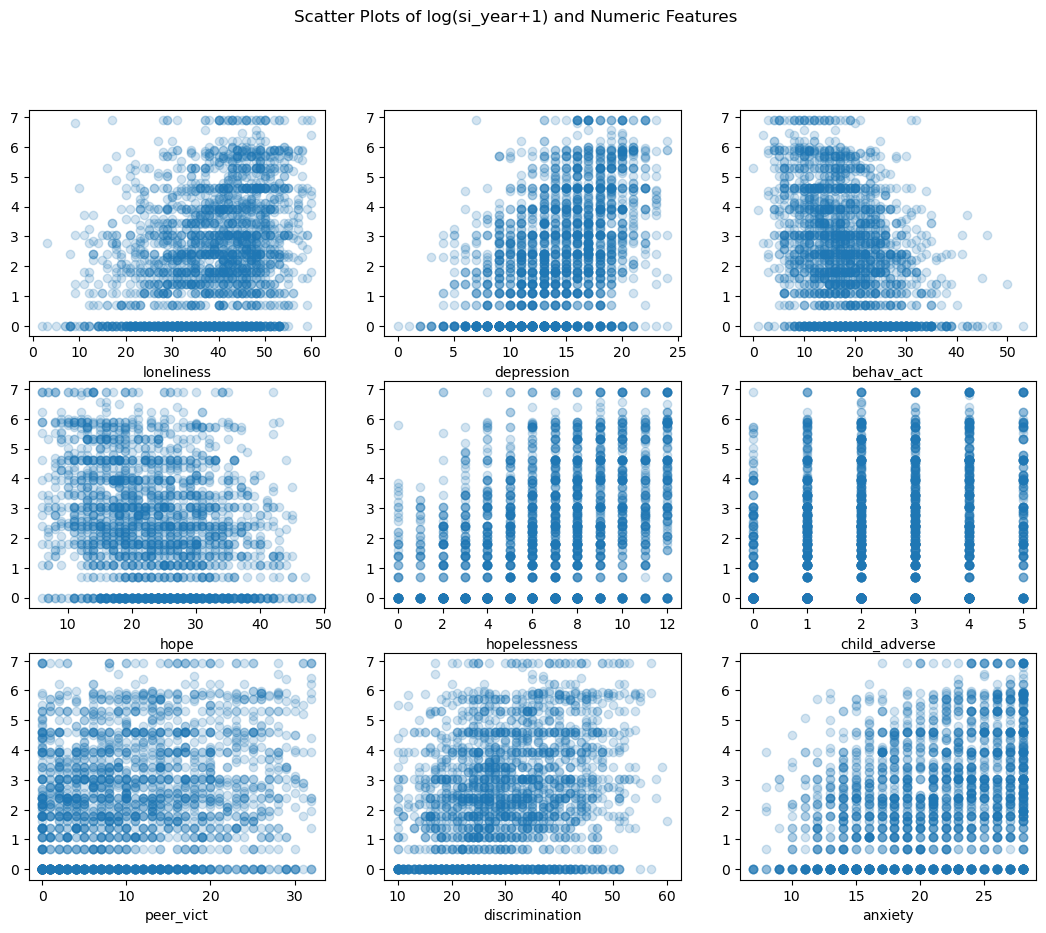

In [68]:
# log(si_year+1) vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of log(si_year+1) and Numeric Features')

axes[0,0].scatter(data['loneliness'], np.log(1+data['si_year']), alpha=0.2)
axes[0,0].set_xlabel('loneliness')
#axes[0,0].set_ylim(0, 300)
axes[0,1].scatter(data['depression'], np.log(1+data['si_year']), alpha=0.2)
axes[0,1].set_xlabel('depression')
#axes[0,1].set_ylim(0, 300)
axes[0,2].scatter(data['behav_act'], np.log(1+data['si_year']), alpha=0.2)
axes[0,2].set_xlabel('behav_act')
#axes[0,2].set_ylim(0, 300)
axes[1,0].scatter(data['hope'], np.log(1+data['si_year']), alpha=0.2)
axes[1,0].set_xlabel('hope')
#axes[1,0].set_ylim(0, 300)
axes[1,1].scatter(data['hopelessness'], np.log(1+data['si_year']), alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
#axes[1,1].set_ylim(0, 300)
axes[1,2].scatter(data['child_adverse'], np.log(1+data['si_year']), alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
#axes[1,2].set_ylim(0, 300)
axes[2,0].scatter(data['peer_vict'], np.log(1+data['si_year']), alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
#axes[2,0].set_ylim(0, 300)
axes[2,1].scatter(data['discrimination'], np.log(1+data['si_year']), alpha=0.2)
axes[2,1].set_xlabel('discrimination')
#axes[2,1].set_ylim(0, 300)
axes[2,2].scatter(data['anxiety'], np.log(1+data['si_year']), alpha=0.2)
axes[2,2].set_xlabel('anxiety')
#axes[2,2].set_ylim(0, 300)

None

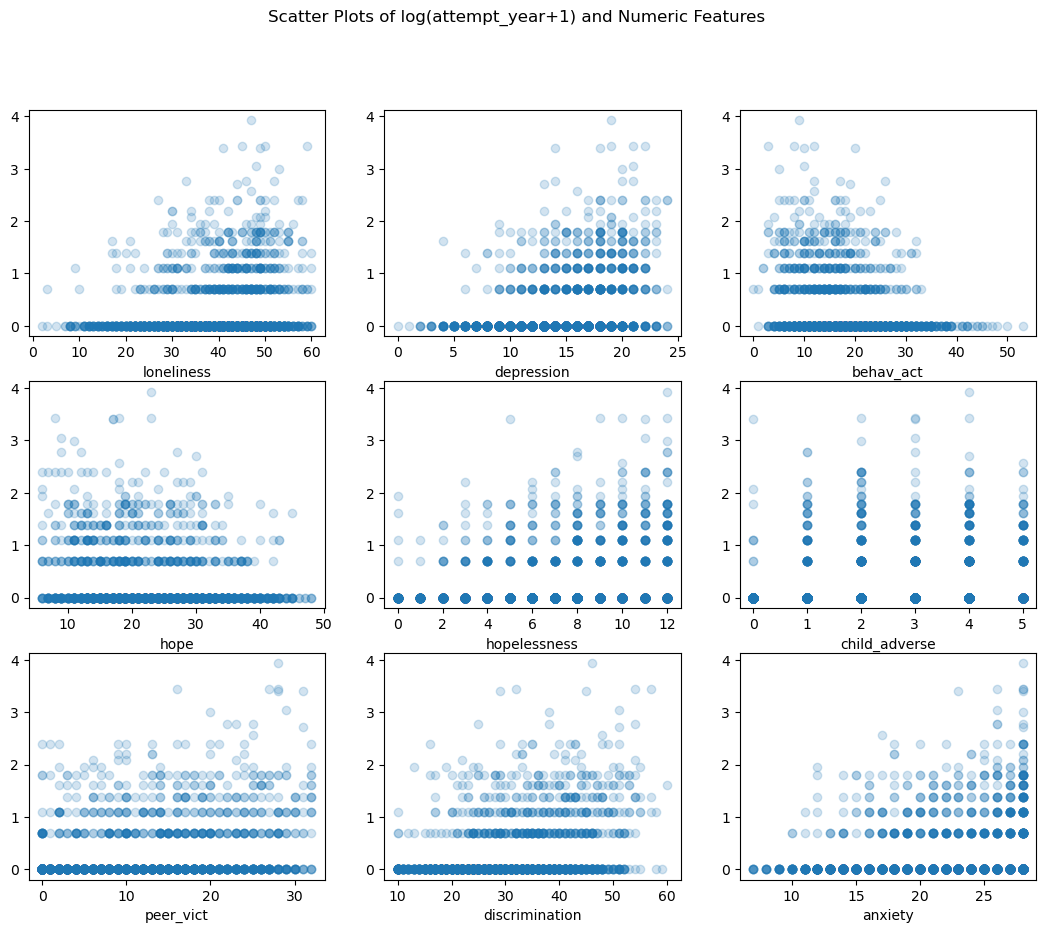

In [69]:
# log(attempt_year+1) vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of log(attempt_year+1) and Numeric Features')

axes[0,0].scatter(data['loneliness'], np.log(1+data['attempt_year']), alpha=0.2)
axes[0,0].set_xlabel('loneliness')
#axes[0,0].set_ylim(0, 30)
axes[0,1].scatter(data['depression'], np.log(1+data['attempt_year']), alpha=0.2)
axes[0,1].set_xlabel('depression')
#axes[0,1].set_ylim(0, 30)
axes[0,2].scatter(data['behav_act'], np.log(1+data['attempt_year']), alpha=0.2)
axes[0,2].set_xlabel('behav_act')
#axes[0,2].set_ylim(0, 30)
axes[1,0].scatter(data['hope'], np.log(1+data['attempt_year']), alpha=0.2)
axes[1,0].set_xlabel('hope')
#axes[1,0].set_ylim(0, 30)
axes[1,1].scatter(data['hopelessness'], np.log(1+data['attempt_year']), alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
#axes[1,1].set_ylim(0, 30)
axes[1,2].scatter(data['child_adverse'], np.log(1+data['attempt_year']), alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
#axes[1,2].set_ylim(0, 30)
axes[2,0].scatter(data['peer_vict'], np.log(1+data['attempt_year']), alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
#axes[2,0].set_ylim(0, 30)
axes[2,1].scatter(data['discrimination'], np.log(1+data['attempt_year']), alpha=0.2)
axes[2,1].set_xlabel('discrimination')
#axes[2,1].set_ylim(0, 30)
axes[2,2].scatter(data['anxiety'], np.log(1+data['attempt_year']), alpha=0.2)
axes[2,2].set_xlabel('anxiety')
#axes[2,2].set_ylim(0, 30)

None

It appears that many of the features may have relationships with the count targets that would be better captured as quadratic vs. linear, but not in models using a log-link function.

In [70]:
# save final dataframe to csv to bypass this preprocessing in the future 
data.to_csv('data_preproc.csv', index=False)